# Classify the behaviors of Green Turtle from acceleration data

African Institute for Mathematical Sciences

Machine Learning for Ecology Research Group

## Download the preprocessed data files

In [1]:
!pip install gdown

In [2]:
import os
HOME = os.getcwd()

In [3]:
import gdown

In [4]:
!gdown --id 1et2ILDxMGDN0odVTVMHu4ppnKYTJcP

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1et2ILDxMGDN0odVTVMHu4pBQpnKYTJcP
From (redirected): https://drive.google.com/uc?id=1et2ILDxMGDN0odVTVMHu4pBQpnKYTJcP&confirm=t&uuid=6fe0e279-f873-462b-aca6-9936e0935f64
To: /kaggle/working/Green_turtle.zip
100%|█████████████████████████████████████████| 347M/347M [00:02<00:00, 141MB/s]


In [5]:
import zipfile

In [6]:
with zipfile.ZipFile("Green_turtle.zip", 'r') as zip_ref:
  zip_ref.extractall()

## Librairies

In [8]:
import json
import glob
import os
import datetime
import shutil
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
import keras
import scipy
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

2024-03-26 14:25:45.868934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 14:25:45.869026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 14:25:45.998295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Create a memo to save all the parameters of the different experiments

In [10]:
memo=pd.Series()

## Function to create a folder to save the results

In [11]:
def create_new_folder(folder_out, model):

        now = datetime.datetime.now()
        today=now.strftime("%Y_%m_%d")
        dir_out=folder_out+"/model="+today+"_"+model


        if os.path.exists(dir_out):
            shutil.rmtree(dir_out)
            print("we clear the directory:",dir_out)
        else:
            print("we create the directory:",dir_out)

        """création des dossiers """
        os.makedirs(dir_out)
        return dir_out

## Load the data

#### load first the dictionary containing the information about the data

In [12]:
FOLDER_NAME=memo['Folder_data']="Data_Acceleration_GreenTurtle_preprocessed"

In [13]:
def load_dico(path,key_int=False,print_me=False):
    with open(path) as f:
        dico_str = json.loads(json.load(f))

    if key_int:
        conv_key=lambda k:int(k)
    else:
        conv_key=lambda k:k

    dico={conv_key(k):v for k,v in dico_str.items()}

    if print_me:
        print(dico)

    return dico

In [14]:
dico_info=load_dico(FOLDER_NAME+"/dico_info.json",print_me=True);
behName_to_behInd=load_dico(FOLDER_NAME+ "/behName_to_behInd_cat.json",print_me=True);
behInd_to_behName=load_dico(FOLDER_NAME+"/behInd_to_behName_cat.json",key_int=True,print_me=True)

{'RESAMPLING_STEP_S': 0.05, 'col_names': ['Accelerometer X [m/s²]', 'Accelerometer Y [m/s²]', 'Accelerometer Z [m/s²]', 'Gyroscope X [mrad/s]', 'Gyroscope Y [mrad/s]', 'Gyroscope Z [mrad/s]', 'Depth [m]', 'beh', 'beh_merge', 'StX', 'StY', 'StZ', 'DX', 'DY', 'DZ', 'VeDBA', 'Pressure_corr', 'Pressure_diff']}
{'Other': 0, 'Breathing': 1, 'Feeding': 2, 'Gliding': 3, 'Resting': 4, 'Scratching': 5, 'Swimming': 6}
{0: 'Other', 1: 'Breathing', 2: 'Feeding', 3: 'Gliding', 4: 'Resting', 5: 'Scratching', 6: 'Swimming'}


### Define the classes

In [15]:
CLASSES=['Other', 'Breathing', 'Feeding', 'Gliding', 'Resting', 'Scratching', 'Swimming']

#### load the matrix of each individual (n=13)

There are 16 different files from 13 different individuals. Each matrix contains the annotated acc/gyro/magneto/pression sequences plus various calculated variables.

## get the name of the files

In [16]:
GT_names=[i.split("/")[1][:-4] for i in glob.glob(FOLDER_NAME+'/*.npy')]

In [17]:
GT_names

['CC-07-47_14-02-2018',
 'CC-07-107_11-02-2019',
 'CC-07-48_08-10-2018',
 'CC-07-48_22-05-2018',
 'CC-07-48_08-04-2019_2',
 'CC-07-108_11-02-2019',
 'CC-07-48_04-10-2018',
 'CC-07-48_26-05-2018',
 'CC-07-48_18-02-2019',
 'CC-07-48_08-04-2019_1',
 'CC-07-48_10-10-2018',
 'CC-07-115_14-05-2019',
 'CC-07-48_08-04-2019_3',
 'CC-07-59_20-05-2018',
 'CC-07-48_06-10-2018',
 'CC-07-115_13-05-2019']

### based on the dictionary , we can see the name of the columns of our numpy matrix

In [18]:
for i, name in enumerate(dico_info['col_names']):
  print(i, name)


0 Accelerometer X [m/s²]
1 Accelerometer Y [m/s²]
2 Accelerometer Z [m/s²]
3 Gyroscope X [mrad/s]
4 Gyroscope Y [mrad/s]
5 Gyroscope Z [mrad/s]
6 Depth [m]
7 beh
8 beh_merge
9 StX
10 StY
11 StZ
12 DX
13 DY
14 DZ
15 VeDBA
16 Pressure_corr
17 Pressure_diff


### Here we are going to select the columns that we want to use for our analysis

In [19]:
DESCRIPTORS_SELEC=[0,1,2,3,4,5,9,10,11,12,13,14,15,16]
LABEL_COL=8  #here I am indicating the column to use as label

### A cell just to check wich columns we are going to use based on `DESCRIPTORS_SELEC`

In [20]:
DESC_NAMES_SELEC=[]
for i,name in enumerate(dico_info['col_names']):
    if i in DESCRIPTORS_SELEC:
        prefix=""
        DESC_NAMES_SELEC.append(name)
    else:
        prefix="-----suppressed----->"
    print(prefix,i,name)

 0 Accelerometer X [m/s²]
 1 Accelerometer Y [m/s²]
 2 Accelerometer Z [m/s²]
 3 Gyroscope X [mrad/s]
 4 Gyroscope Y [mrad/s]
 5 Gyroscope Z [mrad/s]
-----suppressed-----> 6 Depth [m]
-----suppressed-----> 7 beh
-----suppressed-----> 8 beh_merge
 9 StX
 10 StY
 11 StZ
 12 DX
 13 DY
 14 DZ
 15 VeDBA
 16 Pressure_corr
-----suppressed-----> 17 Pressure_diff


### Now we load the matrices, we are going to load them into a dictionary associated with the name of the file/individual
### We do the same for the labels

In [21]:
Matrices={}
Labels={}
FREQ=1/dico_info['RESAMPLING_STEP_S']


for name in GT_names:
    print(name)
    full_name=FOLDER_NAME+"/"+name+".npy"
    if not os.path.exists(full_name):
        assert 1==0,"the file:"+full_name+" doesn't exist"
    else:
        full_mat=np.load(full_name)
        label= full_mat[:,LABEL_COL]

        mat=full_mat[:,DESCRIPTORS_SELEC]
        print("loading the matrice:"+name)
        print("shape:",mat.shape)
        print("Time in seconds:",len(mat)/FREQ)
        print("Time in hours:",round(len(mat)/FREQ/60/60,2))
        print("              ")
        Matrices[name]=mat
        Labels[name]=label


CC-07-47_14-02-2018
loading the matrice:CC-07-47_14-02-2018
shape: (105362, 14)
Time in seconds: 5268.1
Time in hours: 1.46
              
CC-07-107_11-02-2019
loading the matrice:CC-07-107_11-02-2019
shape: (346142, 14)
Time in seconds: 17307.1
Time in hours: 4.81
              
CC-07-48_08-10-2018
loading the matrice:CC-07-48_08-10-2018
shape: (535201, 14)
Time in seconds: 26760.05
Time in hours: 7.43
              
CC-07-48_22-05-2018
loading the matrice:CC-07-48_22-05-2018
shape: (286161, 14)
Time in seconds: 14308.05
Time in hours: 3.97
              
CC-07-48_08-04-2019_2
loading the matrice:CC-07-48_08-04-2019_2
shape: (88800, 14)
Time in seconds: 4440.0
Time in hours: 1.23
              
CC-07-108_11-02-2019
loading the matrice:CC-07-108_11-02-2019
shape: (160292, 14)
Time in seconds: 8014.6
Time in hours: 2.23
              
CC-07-48_04-10-2018
loading the matrice:CC-07-48_04-10-2018
shape: (284021, 14)
Time in seconds: 14201.05
Time in hours: 3.94
              
CC-07-48_26-0

In [22]:
Matrices[GT_names[0]].shape

(105362, 14)

In [23]:
print(Labels[GT_names[0]])
print(Labels[GT_names[0]].shape)
print(np.unique(Labels[GT_names[0]], return_counts=True))

[6. 6. 6. ... 6. 6. 6.]
(105362,)
(array([1., 6.]), array([   716, 104646]))


## Split our data into Training/Validation dataset

There is two ways to do it :
* do it randomly
* carefully select individuals to ensure that all behaviours are well represented in each data set. This is the difficulty of small data sets in ecology

<br>

Very important : to test the ability of the algorithm to perform on new individuals, the individuals must be distributed separately between the three data sets.



In [24]:
Matrices['CC-07-48_18-02-2019'].shape

(559219, 14)

In [25]:
NAMES_TRAIN=memo["NAMES_TRAIN"]=[
                     'CC-07-48_18-02-2019', #1
                     'CC-07-48_06-10-2018', #2
                     'CC-07-48_04-10-2018', #3
                     'CC-07-115_13-05-2019', #4
                     'CC-07-115_14-05-2019', #4
                     'CC-07-48_08-04-2019_1', #5
                     'CC-07-48_08-04-2019_2', #5
                     'CC-07-48_08-04-2019_3', #5
                     'CC-07-48_22-05-2018', #6
                      'CC-07-108_11-02-2019', #7
                    ]

NAMES_VAL=memo["NAMES_VAL"]=[
    'CC-07-59_20-05-2018', #8
    'CC-07-47_14-02-2018', #9
    'CC-07-48_10-10-2018',  #10

    ]

NAMES_TEST=memo["NAMES_TEST"]=[
    'CC-07-48_26-05-2018', #11
    'CC-07-107_11-02-2019', #12
    'CC-07-48_08-10-2018', #13
    ]


NAMES_ALL=NAMES_TRAIN+NAMES_VAL+NAMES_TEST

## Deep Learning : CNN

### Generate windows

We first need to build the dataset that we are going to use to train the model

### CNN architecture

In [26]:
import tensorflow as tf
from tensorflow.keras import backend, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool1D, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

### Evaluate the CNN

In [51]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize, axe,
                          title,
                          cmap="jet",
                          precision=2,
                         ):

    y_true=y_true.astype(int)
    y_pred=y_pred.astype(int)

    np.set_printoptions(precision=precision)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    # print("Confusion matrix, without normalization:")
    # print(cm)

    if normalize:
      if axe=="col" :
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
      elif axe=="row":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
        # print(cm)


    fig, ax = plt.subplots(figsize=(12,12))
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.'+str(precision)+'f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "coral")

    # Customize title and labels
    ax.set_title(title, pad = 20, fontsize=18)
    ax.set_xlabel('Predicted label', fontsize=14, labelpad=15)
    ax.set_ylabel('True label', fontsize=14, labelpad=15)
    
    fig.tight_layout()
    plt.savefig('confusion_matrix.svg', format='svg')

## Function to create our data

In [28]:
def create_X_Y_data(Data, label_name, window_size=100, slide_size=50):

    X, Y = [], []
    for label in label_name:
        start = 0

        # Iterate through the whole file
        while start + window_size <= len(Data[label]):

            x = Matrices[label][start:start+window_size]
            y = Labels[label][start:start+window_size]

            X.append(x)

            # Get the most common label within the window
            most_commom_label = max(set(y), key=y.tolist().count)

            # Convert to categorical since with have 7 different classes
            Y.append(to_categorical(most_commom_label, num_classes = len(CLASSES)))

            start = start + window_size - slide_size

    return np.asarray(X), np.asarray(Y)


## Create data

In [29]:
X_train, Y_train = create_X_Y_data(Matrices, NAMES_TRAIN)
X_test, Y_test = create_X_Y_data(Matrices, NAMES_TEST)
X_val, Y_val = create_X_Y_data(Matrices, NAMES_VAL)

## Create a 1D VNet model

In [40]:
from keras.layers import Input, Conv1D, Conv1DTranspose, Concatenate, Activation, PReLU, Dropout
from keras.models import Model

def convolution_block(x, filters, kernel_size):
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = PReLU()(x)
    return x

def VNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Left side of the network
    conv1 = convolution_block(inputs, filters=16, kernel_size=5)
    conv2 = convolution_block(conv1, filters=32, kernel_size=5)

    # Downsampling
    downsampled = Conv1D(32, 2, strides=2)(conv2)

    # Right side of the network
    upsampled = Conv1DTranspose(32, 2, strides=2)(downsampled)
    concatenated = Concatenate(axis=-1)([conv1, upsampled])
    conv3 = convolution_block(concatenated, filters=32, kernel_size=5)
    conv4 = convolution_block(conv3, filters=16, kernel_size=5)

    flattened = Flatten()(conv4)
    flattened = Dropout(0.2)(flattened)

    # Segmentation
    outputs = Dense(num_classes, activation='softmax')(flattened)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [41]:

input_shape = X_train[0].shape
num_classes = len(CLASSES)

# Create the model
model = VNet(input_shape, num_classes)

In [42]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 14)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 100, 16)   │      1,136 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_4 (PReLU)   │ (None, 100, 16)   │      1,600 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 100, 32)   │      2,592 │ p_re_lu_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_5 (PReLU)   │ (None, 100, 32)   │      3,200 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 50, 32)    │      2,080 │ p_re_lu_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_1  │ (None, 100, 32)   │      2,080 │ conv1d_7[0][0]    │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100, 48)   │          0 │ p_re_lu_4[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 100, 32)   │      7,712 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_6 (PReLU)   │ (None, 100, 32)   │      3,200 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 100, 16)   │      2,576 │ p_re_lu_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_7 (PReLU)   │ (None, 100, 16)   │      1,600 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1600)      │          0 │ p_re_lu_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1600)      │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │     11,207 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,983 (152.28 KB)

 Trainable params: 38,983 (152.28 KB)

 Non-trainable params: 0 (0.00 B)

## Compile the model

In [43]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

## Fit the model

In [44]:
history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_val, Y_val), batch_size=32)

Epoch 1/25
  48/2006 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4403 - loss: 9.0083   

W0000 00:00:1711465842.983497      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7934 - loss: 1.1574

W0000 00:00:1711465851.716334      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711465852.771513      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2006/2006 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.7934 - loss: 1.1571 - val_accuracy: 0.8430 - val_loss: 0.4753
Epoch 2/25
  50/2006 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8798 - loss: 0.4866

W0000 00:00:1711465853.909105      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2006/2006 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8875 - loss: 0.3840 - val_accuracy: 0.8899 - val_loss: 0.3700
Epoch 3/25
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9049 - loss: 0.3206 - val_accuracy: 0.9010 - val_loss: 0.3389
Epoch 4/25
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9117 - loss: 0.2888 - val_accuracy: 0.9062 - val_loss: 0.3020
Epoch 5/25
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9171 - loss: 0.2707 - val_accuracy: 0.8944 - val_loss: 0.3539
Epoch 6/25
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9162 - loss: 0.2753 - val_accuracy: 0.9051 - val_loss: 0.3160
Epoch 7/25
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9200 - loss: 0.2609 - val_accuracy: 0.8980 - val_loss: 0.3273
Epoch 8/25
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9204 - loss: 0.2595 - val_accuracy: 0.8885 - val_loss: 0.3476
Epoch 9/25
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9191 - loss: 0.2529 - val_accurac

## Plot History function

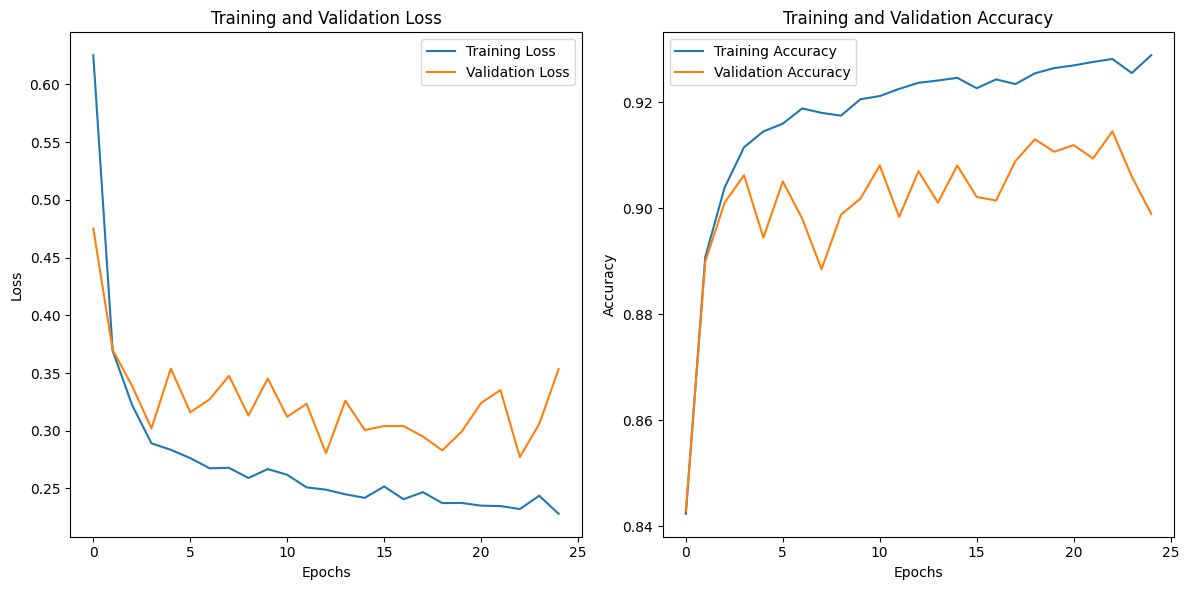

In [50]:
def plot_training_progress(history):
    # Plot training loss vs validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy vs validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    
    plt.savefig('history.svg', format='svg')
    plt.show()

# Usage:
plot_training_progress(history)


# Compute the accuracy of the model

In [46]:
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss: {:.2f}".format(loss))
print("Test Accuracy: {:.2f}%".format(accuracy*100))

718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8740 - loss: 0.4769
Test Loss: 0.36
Test Accuracy: 89.76%


W0000 00:00:1711466014.009337      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Since the reference mentioned that they used dice base loss, for the future work, we can try to use that loss and hope to see improvement in our model.

# Make prediction

In [47]:
y_predict = model.predict(X_test)
y_hat = np.argmax(y_predict, axis=1)
y_true = np.argmax(Y_test, axis=1)

718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


# Print classification metrics

### Classification report

In [48]:
print(classification_report(y_true, y_hat, target_names=CLASSES))

              precision    recall  f1-score   support

       Other       0.52      0.14      0.22       302
   Breathing       0.95      0.92      0.94      2231
     Feeding       0.65      0.49      0.56       654
     Gliding       0.88      0.54      0.67      1131
     Resting       0.94      0.99      0.96     11900
  Scratching       0.67      0.72      0.69       724
    Swimming       0.85      0.88      0.86      6027

    accuracy                           0.90     22969
   macro avg       0.78      0.67      0.70     22969
weighted avg       0.89      0.90      0.89     22969



### Confusion matrix

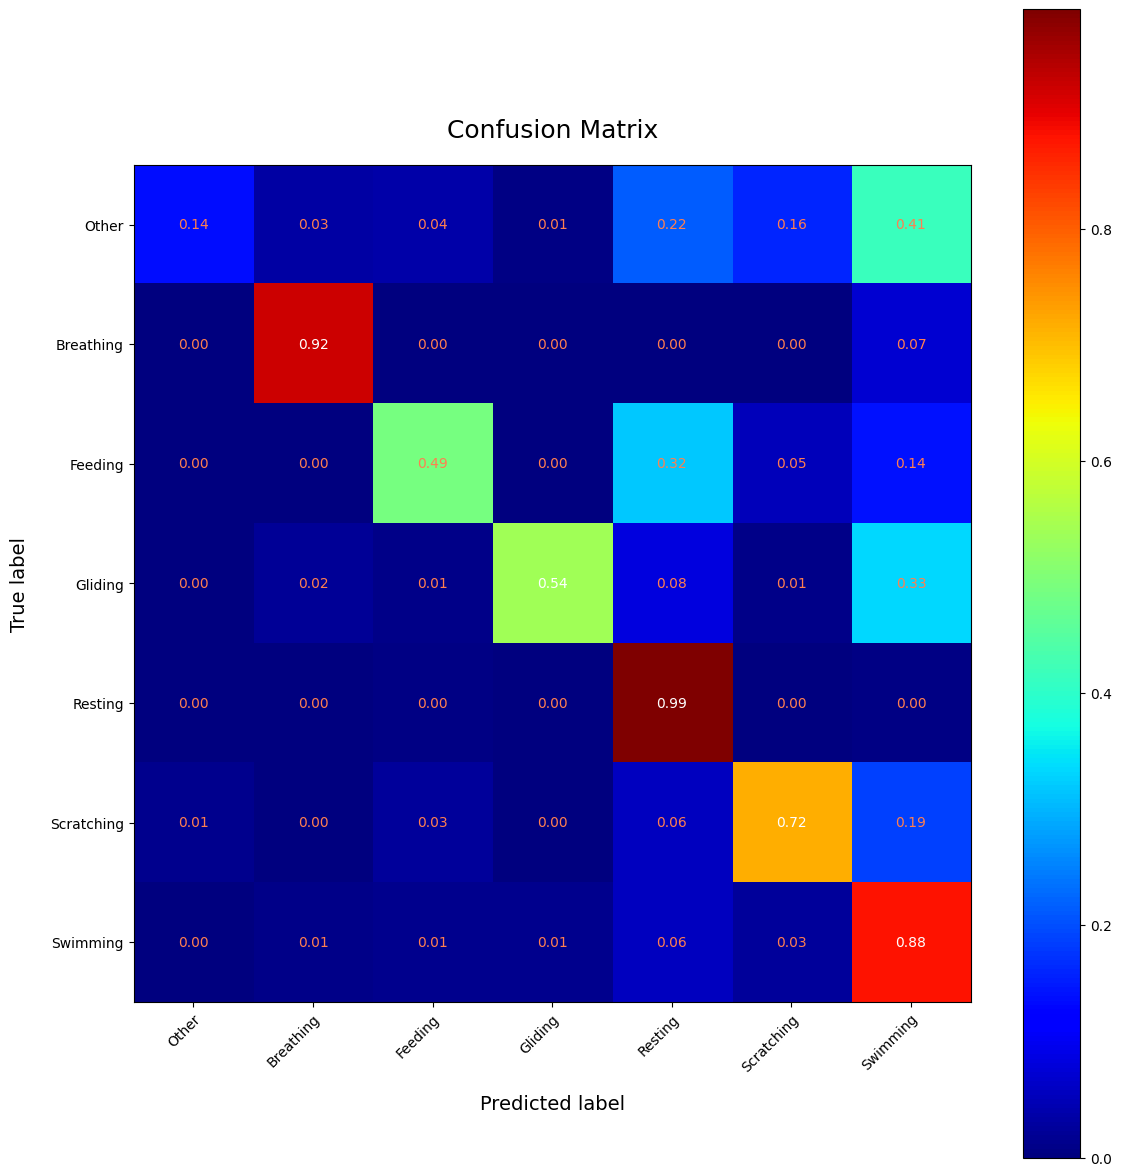

In [52]:
plot_confusion_matrix(y_true, y_hat, classes=CLASSES, normalize=True, axe="row", title="Confusion Matrix")